In [67]:
from typing import TypedDict, Annotated, Optional
from langgraph.graph import add_messages, StateGraph, END, START
from langchain_cerebras import ChatCerebras
from dotenv import load_dotenv
from langgraph.checkpoint.memory import MemorySaver
from uuid import uuid4
import json
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.prebuilt import ToolNode, tools_condition


load_dotenv()

model = ChatCerebras(model ="llama-3.3-70b")

In [ ]:
from datetime import datetime, timezone, timedelta

from langchain_core.tools import BaseTool

#Primera toool que retorna la fecha y hora actual
class CurrentTimeTool(BaseTool):
    name: str = "fecha_hora_actual"
    description: str = "Retorna la fecha y hora actual en formato legible."

    def _run(self) -> str:
        """Synchronous current time lookup."""
        now = datetime.now(timezone(timedelta(hours=-5)))
        return now.strftime("%c")

    async def _arun(self) -> str:
        """Asynchronous current time lookup."""
        now = datetime.now(timezone(timedelta(hours=-5)))
        return now.strftime("%c")

In [ ]:
from langchain_community.tools import DuckDuckGoSearchRun

def search_duckduckgo(query: str):
    """Searches DuckDuckGo using LangChain's DuckDuckGoSearchRun tool."""
    search = DuckDuckGoSearchRun()
    return search.invoke(query)

In [82]:
tools = [CurrentTimeTool(), DuckDuckGoSearchRun()]
llm_with_tools = model.bind_tools(tools)
memory = MemorySaver()

c:\Users\JuanEstebanGarciaGal\Documents\IBM\Chatbot-Recursos\Cuadernos\venv\Lib\site-packages\langchain_core\tools\base.py:1314: PydanticDeprecatedSince20: The `__fields__` attribute is deprecated, use `model_fields` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  fields = getattr(cls, "model_fields", {}) or getattr(cls, "__fields__", {})
c:\Users\JuanEstebanGarciaGal\Documents\IBM\Chatbot-Recursos\Cuadernos\venv\Lib\site-packages\langchain_core\tools\base.py:1314: PydanticDeprecatedSince20: The `__fields__` attribute is deprecated, use `model_fields` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  fields = getattr(cls, "model_fields", {}) or getattr(cls, "__fields__", {})
c:\Users\JuanEstebanGarciaGal\Documents\IBM\Chatbot-Recursos\Cuadernos\venv\Lib\site-packages\langchain_core\tools\base.py:1314: Pyd

In [84]:

response = llm_with_tools.invoke("Busca informacion de la noticia del CEO que fue atrapado siendo infiel")

print("=== content ===")
print(response.content)

print("\n=== additional_kwargs ===")
print(response.additional_kwargs)

print("\n=== response_metadata ===")
print(response.response_metadata)

print("\n=== tool_calls ===")
print(response.tool_calls)

print("\n=== usage_metadata ===")
print(response.usage_metadata)

=== content ===


=== additional_kwargs ===
{'tool_calls': [{'id': '3eea46d70', 'function': {'arguments': '{"query": "CEO infiel noticia"}', 'name': 'duckduckgo_search'}, 'type': 'function'}], 'refusal': None}

=== response_metadata ===
{'token_usage': {'completion_tokens': 17, 'prompt_tokens': 324, 'total_tokens': 341, 'completion_tokens_details': None, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'llama-3.3-70b', 'system_fingerprint': 'fp_d9197bd9bfb96c41ef64', 'id': 'chatcmpl-81084871-cbe6-42d3-8e9e-4903f72a8c9a', 'service_tier': None, 'finish_reason': 'tool_calls', 'logprobs': None}

=== tool_calls ===
[{'name': 'duckduckgo_search', 'args': {'query': 'CEO infiel noticia'}, 'id': '3eea46d70', 'type': 'tool_call'}]

=== usage_metadata ===
{'input_tokens': 324, 'output_tokens': 17, 'total_tokens': 341, 'input_token_details': {'cache_read': 0}, 'output_token_details': {}}


In [85]:
from langchain_core.messages import HumanMessage, AIMessage, ToolMessage
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

class State(TypedDict):
    messages: Annotated[list, add_messages]

async def model_node(state: State):
    result = await llm_with_tools.ainvoke(state["messages"])
    return {"messages": [result]}

async def tools_router(state: State):
    last_message = state["messages"][-1]
    if hasattr(last_message, "tool_calls") and last_message.tool_calls:
        return "tool_node"
    else:
        return END
    
#La función tool_node se encarga de procesar las llamadas a herramientas
tool_node = ToolNode(tools = tools)
async def tool_node_down(state: State):
    tools_calls = state["messages"][-1].tool_calls

    print(f"Tool calls: {tools_calls}")

    tool_messages = []

    for tool_call in tools_calls:
        tool_name = tool_call["name"]
        tool_args = tool_call["args"]
        tool_id = tool_call["id"]

        if tool_name == "fecha_hora_actual":
            data_time_result = await CurrentTimeTool().ainvoke(tool_args)

            print(f"Tool result: {data_time_result}")

            tool_message = ToolMessage(
                content=str(data_time_result),
                tool_call_id=tool_id,
                name=tool_name
            )

            tool_messages.append(tool_message)
    
    return {"messages": tool_messages}


graph_builder = StateGraph(State)

graph_builder.add_node("model_node", model_node)
graph_builder.add_node("tool_node", tool_node)

graph_builder.add_edge(START, "model_node")

# Se debe proveer un diccionario que mapee el resultado del router a los nodos.
# Si el router devuelve "tool_node", va a "tool_node". Si devuelve END, termina.
graph_builder.add_conditional_edges(
    "model_node",
    tools_router,
    {
        "tool_node": "tool_node",
        END: END
    }
)

graph_builder.add_edge("tool_node", "model_node")

graph = graph_builder.compile(checkpointer=memory)



c:\Users\JuanEstebanGarciaGal\Documents\IBM\Chatbot-Recursos\Cuadernos\venv\Lib\site-packages\langchain_core\tools\base.py:1314: PydanticDeprecatedSince20: The `__fields__` attribute is deprecated, use `model_fields` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  fields = getattr(cls, "model_fields", {}) or getattr(cls, "__fields__", {})
c:\Users\JuanEstebanGarciaGal\Documents\IBM\Chatbot-Recursos\Cuadernos\venv\Lib\site-packages\langchain_core\tools\base.py:1314: PydanticDeprecatedSince20: The `__fields__` attribute is deprecated, use `model_fields` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  fields = getattr(cls, "model_fields", {}) or getattr(cls, "__fields__", {})


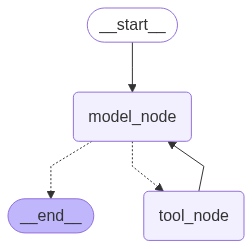

In [86]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API
        )
                     
    )
)


In [ ]:
config = {
    "configurable": {
        "thread_id": 6
    }
}

# Use async for to iterate over the async generator
async for event in graph.astream_events({
    "messages": [HumanMessage(content="Hi, I'm Juan Esteban")],
}, config=config, version="v2"):
    print(event)

{'event': 'on_chain_start', 'data': {'input': {'messages': [HumanMessage(content="Hi, I'm Harish", additional_kwargs={}, response_metadata={})]}}, 'name': 'LangGraph', 'tags': [], 'run_id': '631e7716-f633-41f1-85d1-bd32288911a0', 'metadata': {'thread_id': 6}, 'parent_ids': []}
{'event': 'on_chain_start', 'data': {'input': {'messages': [HumanMessage(content="Hi, I'm Harish", additional_kwargs={}, response_metadata={}, id='f3e9edc6-5289-49d7-aa78-8e75186a67c3')]}}, 'name': 'model_node', 'tags': ['graph:step:1'], 'run_id': '8a27dcb3-d956-4a99-ba03-6ffa4c1c0f65', 'metadata': {'thread_id': 6, 'langgraph_step': 1, 'langgraph_node': 'model_node', 'langgraph_triggers': ('branch:to:model_node',), 'langgraph_path': ('__pregel_pull', 'model_node'), 'langgraph_checkpoint_ns': 'model_node:ad518c34-889c-ad88-a4ce-5d88cc2e9703'}, 'parent_ids': ['631e7716-f633-41f1-85d1-bd32288911a0']}
{'event': 'on_chat_model_start', 'data': {'input': {'messages': [[HumanMessage(content="Hi, I'm Harish", additional_k

In [ ]:
config = {
    "configurable": {
        "thread_id": 7
    }
}

# Use async for to iterate over the async generator
async for event in graph.astream_events({
    "messages": [HumanMessage(content="Cual es mi nombre")],
}, config=config, version="v2"):
    if event["event"] == "on_chat_model_stream":
        print(event["data"]["chunk"].content, end="", flush=True)

Tu nombre es Juan. Me lo dijiste al principio de nuestra conversación.